In [34]:
!jt -t onedork
from jupyterthemes import jtplot
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

jtplot.style(theme='monokai')
plt.rcParams.update({
    "text.usetex": True,
    "axes.labelsize": 20,
    "axes.labelweight": "bold",
    "axes.titlesize": 25,
    "axes.titleweight": "bold",
    "figure.titlesize": 30,
    "figure.titleweight": "bold",
    "font.family": "sans-serif",
    "font.sans-serif": ["Calibri"],
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,})

px = 1/plt.rcParams['figure.dpi']

# Introduction to Hull-White

## The Model

<div style="background: #61afef;
            border-radius: 10px;
            color: #1d1e23;
            horizontal-align: middle;
            margin: auto;
            padding: 10px 30px 10px 10px;
            text-align: center;
            width: 60%;">
$$
    \mathrm{d}r(t) = \left( \theta(t) - \alpha r(t)\right)\mathrm{d}t + \sigma(t) \mathrm{d} W(t)
$$
</div>

* $\theta(t)$ the mean reversion level (i.e. $\lim\limits_{t\rightarrow\infty} r(t) = \theta(t)$).
* $\alpha$ the mean reversion speed (i.e. the rate at which $r(t)$ converges to $\theta(t)$).
* $\sigma(t)$ the volatility which may be constant (for pricing exotics, such as Bermudan swaptions, it needs a term structure).

### Shortcomings

1. Hull-White does not model the term structure of interest rate curves, unlike the HJM or LMM models, therefore it does not account for correlation between points on the curve. Thus, if an instrument payoff depends on multiple forward rates, such as an Asian style interest rate option, HW will be inadequate to model it.
2. Unlike LMM, HW simulates a *fictitious* short rate which is not actually observable in the market. This makes it more difficult to calibrate.


## Model Parameters

### Mean Reversion Speed: $\alpha$

I would argue that there are pairs of values $(\alpha, \sigma)$ which yield the same model. If the vol increases substantially one should be able to offset it with a significantly higher mean reversion speed.

### Mean Reversion Level: $\theta(t)$

It can be shown that $\theta(t)$ needs to satisfy the following relationship with regards to the instantaneous forward curve:

<div style="background: #61afef;
            border-radius: 10px;
            color: #1d1e23;
            horizontal-align: middle;
            margin: auto;
            padding: 10px 30px 10px 10px;
            text-align: center;
            width: 60%;">

$$
    \theta(t) = \alpha f(0,t) + \frac{\partial f(0,t)}{\partial t} + \frac{\sigma^2}{2\alpha}\left(1 - e^{-2\alpha t}\right)
$$
</div>

Let us consider some of the consequences of this equation and focus on each of the terms in more depth.

1. Clearly $\theta(t) \propto \sigma$. The manner in which $\theta(t)$ depends on $\alpha$ is more complicated and explored further below.
1. The second term means that the forward curve needs to be continuous in the first derivative (given an example of this failing to be the case).

First let us consider the third term, $\frac{\sigma^2}{2\alpha}$, which is independent of the forward curve $f(0,t)$.

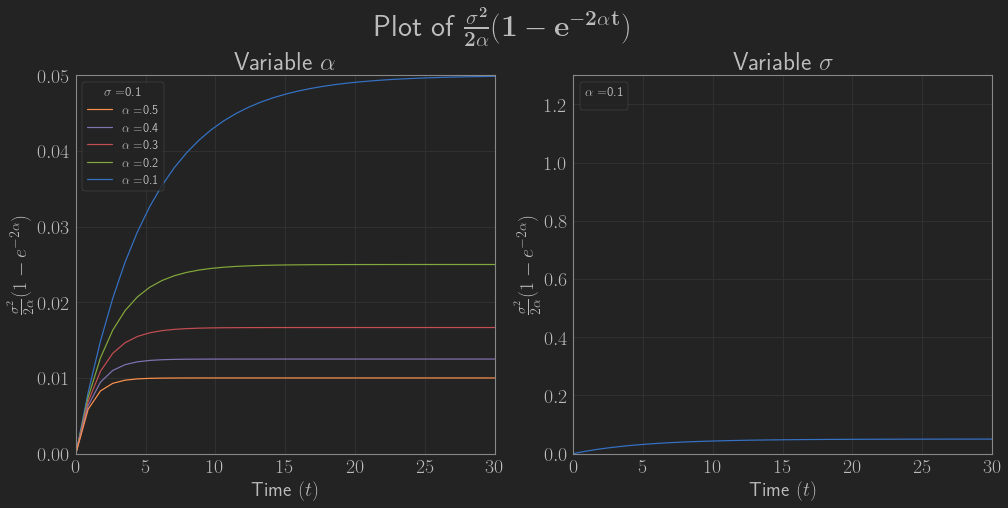

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(1000*px, 500*px))

fig.suptitle(r'Plot of $\mathbf{\frac{\sigma^2}{2\alpha}(1 - e^{-2\alpha t})}$')
cmap = sns.color_palette('crest')

t = np.linspace(0.0, 30.0, 35)

sigma = 0.1
for alpha in [0.1, 0.2, 0.3, 0.4, 0.5]:
    third_term = (sigma**2)/(2*alpha)*(1 - np.exp(-2*alpha*t))
    sns.lineplot(x=t, y=third_term, ax=ax1, label=r'$\alpha=$' + str(alpha), palette=cmap)
    
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1], title=r'$\sigma=$'+str(sigma), loc='upper left')
ax1.set_title(r'Variable $\alpha$')
ax1.set_xlabel(r'Time $(t)$')
ax1.set_ylabel(r'$\frac{\sigma^2}{2\alpha}(1 - e^{-2\alpha})$')
ax1.set_xlim(0, 30)
ax1.set_ylim(0, 0.05)

alpha = 0.1
sigmas = [0.1, 0.2, 0.3, 0.4, 0.5]
third_term_2 = np.zeros([len(sigmas), len(t)])
for i in range(0, 5):
    third_term_2[i, :] = (sigma**2)/(2*alpha)*(1 - np.exp(-2*alpha*t))

sns.lineplot(x=t, y=third_term_2[0, :], ax=ax2)

handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles[::-1], labels[::-1], title=r'$\alpha=$'+str(alpha), loc='upper left')
ax2.set_title(r'Variable $\sigma$')
ax2.set_xlabel(r'Time $(t)$')
ax2.set_ylabel(r'$\frac{\sigma^2}{2\alpha}(1 - e^{-2\alpha})$')
ax2.set_xlim(0, 30)
_ = ax2.set_ylim(0, 1.3)



#### Constant Forward Curve

Clearly if the forward curve is constant then

>$\frac{\partial f(0,t)}{\partial t}=0$,

>$\lim\limits_{t \rightarrow \infty} \frac{\sigma^2}{2\alpha}(1 - e^{-2\alpha t}) = \frac{\sigma^2}{2\alpha}$

>$\lim\limits_{t \rightarrow \infty} \theta(t) = \alpha f(0,t) + \frac{\sigma^2}{2 \alpha}$.
In other words we can see for the simple case of the forward curve being flat/constant $\theta(t)$ and hence $r(t)$ does not simply converge to the initial forward curve.

In general, I would argue that $\lim\limits_{t\rightarrow\infty}\frac{\partial f(0,t)}{\partial t}=0$ assuming the forward curve flattens out in the long run.
Perhaps insert some examples of this.

Note in both cases below r = 0.1 yet the long term behaviour of $\theta(t)$ is far from that.

In [ ]:
t = np.linspace(0, 30, 31)
r = np.zeros(31) + 0.1

alpha = 0.1
sigma = 0.3

px = 1/plt.rcParams['figure.dpi']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(1000*px, 500*px), constrained_layout=True)

dr = np.diff(r)
dr = np.append(dr, dr[-1])

for alpha in [0.1, 0.2, 0.3, 0.4, 0.5]:
    theta = alpha * r + dr + (sigma**2)/(2*alpha)*(1 - np.exp(-2*alpha*t))
    sns.lineplot(x=t, y=theta, ax=ax1, label=f'{alpha=}')  # So basically the third term dominates for a constant curve

ax1.legend(loc='upper left', title='sigma=0.3')

alpha = 0.1
for sigma in [0.1, 0.2, 0.3, 0.4, 0.5]:
    theta = alpha * r + dr + (sigma**2)/(2*alpha)*(1 - np.exp(-2*alpha*t))
    sns.lineplot(x=t, y=theta, ax=ax2, label=f'{sigma=}')

ax2.legend(loc='upper left', title=r'$\alpha=0.1$')

In [ ]:
# Increasing swap curve
r = np.linspace(0.05, 0.15, 31)
t = np.linspace(0, 30, 31)

dr = np.diff(r)
dr = np.append(dr, dr[-1])

sigma = 0.1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(1000*px, 500*px))

for alpha in [0.1, 0.125, 0.15, 0.175, 0.2, 0.25, 0.30]:
    theta = alpha * r + dr + (sigma**2)/(2*alpha)*(1 - np.exp(-2*alpha*t))
    sns.lineplot(x=t, y=theta, label=f'{alpha=}', ax=ax1)

ax1.legend(loc='upper left', title=r'$\sigma=0.3$')

alpha = 0.01

for sigma in [0.1, 0.2, 0.3, 0.4, 0.5]:
    theta = alpha * r + dr + (sigma**2)/(2*alpha)*(1 - np.exp(-2*alpha*t))
    sns.lineplot(x=t, y=theta, label=f'{sigma=}', ax=ax2)

ax2.legend(loc='upper left', title=r'$\alpha=0.1$')


In [ ]:
t = np.linspace(0, 30, 31)
r = np.linspace(0.15, 0.05, 31)

dr = np.diff(r)
dr = np.append(dr, dr[-1])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(1000*px, 500*px), constrained_layout=True)
sigma = 0.1
for alpha in [0.1, 0.2, 0.3, 0.4, 0.5]:
    theta = alpha * r + dr + (sigma**2)/(2*alpha)*(1 - np.exp(-2*alpha*t))
    sns.lineplot(x=t, y=theta, label=f'{alpha=}', ax=ax1)

ax1.legend(loc='upper left', title=r'$\sigma=0.3$')

alpha = 0.1
for sigma in [0.1, 0.2, 0.3, 0.4, 0.5]:
    theta = alpha * r + dr + (sigma**2)/(2*alpha)*(1 - np.exp(-2*alpha*t))
    sns.lineplot(x=t, y=theta, label=f'{alpha=}')

ax2.legend(loc='upper left', title=r'$\alpha=0.1$')

## Risk Neutral Calibration
Here we consider calibration to market instruments and hence calibration to market implied volatilities.

### Swaption Pricing

In order to calibrate the volatility term in Hull-White we need some instrument in the market which provides us with an implied volatility.
Sources may include swaptions, caps, and/or floors.

It turns out that we can price a swaption

## Real World Calibration
Here we consider calibration to historic time series and hence calibration to historic volatilities.


## Simulation

\begin{equation}
    r(t) = x(t) + \phi(t)
\end{equation}

Where
* $x(t)$ is stochastic,
* $\phi(t)$ is deterministic.

<center>

\begin{equation}
    \mathrm{d}x(t) = -\alpha x(t) + \sigma \mathrm{d}W(t),
\end{equation}

$x(0) = 0$

</center>

<center>

\begin{align}
    x(t_{i+1}) - x(t_i) &= -\alpha x(t_i) + \sigma \sqrt{\Delta t} Z \\
    x(t_{i+1}) &= (1 - \alpha) x(t_i) + \sigma \sqrt{\Delta t} Z
\end{align}

\begin{equation}
    Z \sim \mathcal{N}(0,1)
\end{equation}

</center>

In [ ]:
alpha = 0.01
sigma = 0.1
dt = 0.1
x = np.zeros([31, 1000])

for j in range(0, 1000):
    for i in range(0,30):
        x[i+1, j] = (1-alpha)*x[i, j] + sigma * np.sqrt(dt) * np.random.standard_normal(1)

t = [i * dt for i in range(0, 31)]
_ = plt.plot(t, x)
plt.xlim(0, 3)
plt.ylim(-0.5, 0.5)

In [ ]:
alpha = 0.05
sigma = 0.1
dt = 0.1
x = np.zeros([31, 1000])

for j in range(0, 1000):
    for i in range(0,30):
        x[i+1, j] = (1-alpha)*x[i, j] + sigma * np.sqrt(dt) * np.random.standard_normal(1)

t = [i * dt for i in range(0, 31)]
_ = plt.plot(t, x)
plt.xlim(0, 3)
plt.ylim(-0.5, 0.5)

In [ ]:
alpha = 0.1
sigma = 0.1
dt = 0.1
x = np.zeros([31, 1000])

for j in range(0, 1000):
    for i in range(0,30):
        x[i+1, j] = (1-alpha)*x[i, j] + sigma * np.sqrt(dt) * np.random.standard_normal(1)

t = [i * dt for i in range(0, 31)]
_ = plt.plot(t, x)
plt.xlim(0, 3)
plt.ylim(-0.5, 0.5)

In [ ]:
alpha = 0.2
sigma = 0.1
dt = 0.1
x = np.zeros([31, 1000])

for j in range(0, 1000):
    for i in range(0,30):
        x[i+1, j] = (1-alpha)*x[i, j] + sigma * np.sqrt(dt) * np.random.standard_normal(1)

t = [i * dt for i in range(0, 31)]
_ = plt.plot(t, x)
plt.xlim(0, 3)
plt.ylim(-0.5, 0.5)

### Ostrovski's Method

\begin{equation}
x(t) = x(s) + \int\limits_s^t x(y) \mathrm{d}y
\end{equation}

We assume $x(s)$ is known i.e. we have simulated $x$ up to time $s$.


## Unit Tests
1. Observe behaviour of flat initial curve.
1. Observe behaviour of monotonically increasing initial curve.
1. Observe behaviour of monotonically decreasing initial curve.
1. Observe limiting behaviour of Hull-White as $\alpha\rightarrow 0$.
1. Observe limiting behaviour of Hull-White as $\sigma\rightarrow\infty$.
1. Test pricing of bond or FRA with several different vols to ensure they aren't dependent on the vol (as it should be if Hull-White has been implemented correctly).

## References
1. **XVA: Credit, Funding, and Capital Valuation Adjustments**; Wiley Finance Series; *Andrew Green*

# TODO
1. Implement the naive approximation to the stochastic process
2. Implement Ostrovski method of stochastic process
3. Compare 1 and 2
4. Compare to Milstein and Euler-Maruyama
5. See what Brandimarte does in his book
6. Price a bond option using HW analytical formula
7. Price a bond option using HW Monte Carlo
8. Price a swaption using HW analytical formula
9. Price a swaption using HW Motne Carlo
10. Price a cap using HW analytical formula
11. Price a cap using HW Monte Carlo
12. Price a floor using HW analytical formula
13. Price a floor using HW Monte Carlo
14. My gut tells me HW is less well behaved in the short end of the ZAR swap curve where there is a bit of kink.